# CE-Net


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import sys
import os
import json
import h5py
from optparse import OptionParser
import numpy as np
from torch import optim
from PIL import Image
import progressbar
from torch.autograd import Function, Variable
import matplotlib.pyplot as plt
import matplotlib
from torchvision import transforms
from glob import glob
from skimage import io
from sklearn.feature_extraction.image import extract_patches_2d,reconstruct_from_patches_2d
import pickle
from torch.utils.data import Dataset
%matplotlib inline
import cv2
import torch
import torch.nn as nn
from torchvision import models
import torch.nn.functional as F
from functools import partial


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cpu


In [3]:
progress = progressbar.ProgressBar(widgets=[progressbar.Bar('*', '[', ']'), progressbar.Percentage(), ' '])

In [4]:
nonlinearity = partial(F.relu, inplace=True)

In [165]:
class DACblock(nn.Module):
    def __init__(self, channel):
        super(DACblock, self).__init__()
        self.dilate1 = nn.Conv2d(channel, channel, kernel_size=3, dilation=1, padding=1)
        self.dilate2 = nn.Conv2d(channel, channel, kernel_size=3, dilation=3, padding=3)
        self.dilate3 = nn.Conv2d(channel, channel, kernel_size=3, dilation=5, padding=5)
        self.conv1x1 = nn.Conv2d(channel, channel, kernel_size=1, dilation=1, padding=0)
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                if m.bias is not None:
                    m.bias.data.zero_()

    def forward(self, x):
        dilate1_out = nonlinearity(self.dilate1(x))
        dilate2_out = nonlinearity(self.conv1x1(self.dilate2(x)))
        dilate3_out = nonlinearity(self.conv1x1(self.dilate2(self.dilate1(x))))
        dilate4_out = nonlinearity(self.conv1x1(self.dilate3(self.dilate2(self.dilate1(x)))))
        out = x + dilate1_out + dilate2_out + dilate3_out + dilate4_out
        return out


class DACblock_without_atrous(nn.Module):
    def __init__(self, channel):
        super(DACblock_without_atrous, self).__init__()
        self.dilate1 = nn.Conv2d(channel, channel, kernel_size=3, dilation=1, padding=1)
        self.dilate2 = nn.Conv2d(channel, channel, kernel_size=3, dilation=1, padding=1)
        self.dilate3 = nn.Conv2d(channel, channel, kernel_size=3, dilation=1, padding=1)
        self.conv1x1 = nn.Conv2d(channel, channel, kernel_size=1, dilation=1, padding=0)
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                if m.bias is not None:
                    m.bias.data.zero_()

    def forward(self, x):
        dilate1_out = nonlinearity(self.dilate1(x))
        dilate2_out = nonlinearity(self.conv1x1(self.dilate2(x)))
        dilate3_out = nonlinearity(self.conv1x1(self.dilate2(self.dilate1(x))))
        dilate4_out = nonlinearity(self.conv1x1(self.dilate3(self.dilate2(self.dilate1(x)))))
        out = x + dilate1_out + dilate2_out + dilate3_out + dilate4_out

        return out

class DACblock_with_inception(nn.Module):
    def __init__(self, channel):
        super(DACblock_with_inception, self).__init__()
        self.dilate1 = nn.Conv2d(channel, channel, kernel_size=1, dilation=1, padding=0)

        self.dilate3 = nn.Conv2d(channel, channel, kernel_size=3, dilation=1, padding=1)
        self.conv1x1 = nn.Conv2d(2 * channel, channel, kernel_size=1, dilation=1, padding=0)
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                if m.bias is not None:
                    m.bias.data.zero_()

    def forward(self, x):
        dilate1_out = nonlinearity(self.dilate1(x))
        dilate2_out = nonlinearity(self.dilate3(self.dilate1(x)))
        dilate_concat = nonlinearity(self.conv1x1(torch.cat([dilate1_out, dilate2_out], 1)))
        dilate3_out = nonlinearity(self.dilate1(dilate_concat))
        out = x + dilate3_out
        return out


class DACblock_with_inception_blocks(nn.Module):
    def __init__(self, channel):
        super(DACblock_with_inception_blocks, self).__init__()
        self.conv1x1 = nn.Conv2d(channel, channel, kernel_size=1, dilation=1, padding=0)
        self.conv3x3 = nn.Conv2d(channel, channel, kernel_size=3, dilation=1, padding=1)
        self.conv5x5 = nn.Conv2d(channel, channel, kernel_size=5, dilation=1, padding=2)
        self.pooling = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)

        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                if m.bias is not None:
                    m.bias.data.zero_()

    def forward(self, x):
        dilate1_out = nonlinearity(self.conv1x1(x))
        dilate2_out = nonlinearity(self.conv3x3(self.conv1x1(x)))
        dilate3_out = nonlinearity(self.conv5x5(self.conv1x1(x)))
        dilate4_out = self.pooling(x)
        out = dilate1_out + dilate2_out + dilate3_out + dilate4_out
        return out



class PSPModule(nn.Module):
    def __init__(self, features, out_features=1024, sizes=(2, 3, 6, 14)):
        super().__init__()
        self.stages = []
        self.stages = nn.ModuleList([self._make_stage(features, size) for size in sizes])
        self.bottleneck = nn.Conv2d(features * (len(sizes) + 1), out_features, kernel_size=1)
        self.relu = nn.ReLU()

    def _make_stage(self, features, size):
        prior = nn.AdaptiveAvgPool2d(output_size=(size, size))
        conv = nn.Conv2d(features, features, kernel_size=1, bias=False)
        return nn.Sequential(prior, conv)

    def forward(self, feats):
        h, w = feats.size(2), feats.size(3)
        priors = [F.upsample(input=stage(feats), size=(h, w), mode='bilinear') for stage in self.stages] + [feats]
        bottle = self.bottleneck(torch.cat(priors, 1))
        return self.relu(bottle)


class SPPblock(nn.Module):
    def __init__(self, in_channels):
        super(SPPblock, self).__init__()
        self.pool1 = nn.MaxPool2d(kernel_size=[2, 2], stride=2)
        self.pool2 = nn.MaxPool2d(kernel_size=[3, 3], stride=3)
        self.pool3 = nn.MaxPool2d(kernel_size=[5, 5], stride=5)
        #self.pool4 = nn.MaxPool2d(kernel_size=[6, 6], stride=6)

        self.conv = nn.Conv2d(in_channels=in_channels, out_channels=1, kernel_size=1, padding=0)

    def forward(self, x):
        self.in_channels, h, w = x.size(1), x.size(2), x.size(3)
        self.layer1 = F.upsample(self.conv(self.pool1(x)), size=(h, w), mode='bilinear')
        self.layer2 = F.upsample(self.conv(self.pool2(x)), size=(h, w), mode='bilinear')
        self.layer3 = F.upsample(self.conv(self.pool3(x)), size=(h, w), mode='bilinear')
        #self.layer4 = F.upsample(self.conv(self.pool4(x)), size=(h, w), mode='bilinear')

        out = torch.cat([self.layer1, self.layer2, self.layer3, x], 1)

        return out


class DecoderBlock(nn.Module):
    def __init__(self, in_channels, n_filters):
        super(DecoderBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, in_channels // 4, 1)
        self.norm1 = nn.BatchNorm2d(in_channels // 4)
        self.relu1 = nonlinearity

        self.deconv2 = nn.ConvTranspose2d(in_channels // 4, in_channels // 4, 3, stride=2, padding=1, output_padding=1)
        self.norm2 = nn.BatchNorm2d(in_channels // 4)
        self.relu2 = nonlinearity

        self.conv3 = nn.Conv2d(in_channels // 4, n_filters, 1)
        self.norm3 = nn.BatchNorm2d(n_filters)
        self.relu3 = nonlinearity

    def forward(self, x):
        x = self.conv1(x)
        x = self.norm1(x)
        x = self.relu1(x)
        x = self.deconv2(x)
        x = self.norm2(x)
        x = self.relu2(x)
        x = self.conv3(x)
        x = self.norm3(x)
        x = self.relu3(x)

        return x

In [197]:
class CE_Net_(nn.Module):
    def __init__(self, num_channels=4, num_classes=5):
        super(CE_Net_, self).__init__()

        filters = [64,128,256,(512+3)]
        resnet = models.resnet34(pretrained=True)
        self.firstconv = nn.Conv2d(num_channels, 64, 7, padding=3)
        self.firstbn = resnet.bn1
        self.firstrelu = resnet.relu
        self.firstmaxpool = resnet.maxpool
        self.encoder1 = resnet.layer1
        self.encoder2 = resnet.layer2
        self.encoder3 = resnet.layer3
        self.encoder4 = resnet.layer4

        self.dblock = DACblock(512)
        self.spp = SPPblock(512)

        self.decoder4 = DecoderBlock(filters[3], filters[2])
        self.decoder3 = DecoderBlock(filters[2], filters[1])
        self.decoder2 = DecoderBlock(filters[1], filters[0])
        self.decoder1 = DecoderBlock(filters[0], filters[0])

        self.finaldeconv1 = nn.ConvTranspose2d(filters[1], 32, 4, 2, 1)
        self.finalrelu1 = nonlinearity
        self.finalconv2 = nn.Conv2d(32, 32, 10, padding=1)
        self.finalrelu2 = nonlinearity
        self.finalconv3 = nn.Conv2d(32, num_classes, 3, padding=1)

    def forward(self, x):
        # Encoder
        x = self.firstconv(x)
        x = self.firstbn(x)
        x = self.firstrelu(x)
        x = self.firstmaxpool(x)
        e1 = self.encoder1(x)
        e2 = self.encoder2(e1)
        e3 = self.encoder3(e2)
        e4 = self.encoder4(e3)

        # Center
        e4 = self.dblock(e4)
        e4 = F.upsample(e4,size=(5,5),mode='bilinear')
        e4 = self.spp(e4)

        # Decoder
        d4 = self.decoder4(e4) + F.upsample(e3,size=(10,10),mode='bilinear')
        d3 = self.decoder3(d4) + F.upsample(e2,size=(20,20),mode='bilinear')#e2
        #d2 = self.decoder2(d3) + F.upsample(e1,size=(40,40),mode='bilinear')#e1
        #d1 = self.decoder1(d2)

        out = self.finaldeconv1(d3)
        out = self.finalrelu1(out)
        out = self.finalconv2(out)
        out = self.finalrelu2(out)
        out = self.finalconv3(out)

        return out

In [198]:
#### define transform classes for  data augmentation
class Flip(object):
    """
    Flip the image left or right for data augmentation, but prefer original image.
    """
    def __init__(self,ori_probability=0.60):
        self.ori_probability = ori_probability
 
    def __call__(self, sample):
        if random.uniform(0,1) < self.ori_probability:
            return sample
        else:
            img, label = sample['img'], sample['label']
            img_flip = img[:,:,::-1]
            label_flip = label[:,::-1]
            
            return {'img': img_flip, 'label': label_flip}
        
class ToTensor(object):
    """
    Convert ndarrays in sample to Tensors.
    """
    def __init__(self):
        pass

    def __call__(self, sample):
        image, label = sample['img'], sample['label']

        return {'img': torch.from_numpy(image.copy()).type(torch.FloatTensor),
                'label': torch.from_numpy(label.copy()).type(torch.FloatTensor)}

In [199]:

train_img_masks_save_path = 'Pickles/train_img_masks.pickle'
if os.path.exists(train_img_masks_save_path):
    with open(train_img_masks_save_path,'rb') as f:
        train_img_masks = pickle.load(f)
    f.close()
else:
    print('Error! Training Set Pickle not found!')

val_img_masks_save_path = 'Pickles/val_img_masks.pickle'
if os.path.exists(val_img_masks_save_path):
    with open(val_img_masks_save_path,'rb') as f:
        val_img_masks = pickle.load(f)
    f.close()
else:
    print('Error! Validation Set Pickle not found!')

In [200]:
class CustomDataset(Dataset):
    def __init__(self, image_masks, transforms=None): 

        self.image_masks = image_masks
        self.transforms = transforms
    
    def __len__(self):  # return count of sample we have

        return len(self.image_masks)
    
    def __getitem__(self, index):

        image = np.array(self.image_masks[index][0]) # Channel,H, W
        mask = self.image_masks[index][1]
        
        sample = {'img': image, 'label': mask}
        
        if transforms:
            sample = self.transforms(sample)
            
        return sample

train_dataset = CustomDataset(train_img_masks, transforms=transforms.Compose([Flip(),ToTensor()]))
val_dataset = CustomDataset(val_img_masks, transforms=transforms.Compose([Flip(),ToTensor()]))


In [201]:
# Create Model object from the class defined above. Input channels = 4, output channels = 5
net = CE_Net_(num_channels=4, num_classes=5).to(device,dtype=torch.float32)
net.to(device) 
# if using GPU
# If continuing from previously saved model, use 
# net.load_state_dict(torch.load('PATH TO SAVED MODEL FILE'))
print(net)

# This shows the number of parameters in the network
n_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print('Number of parameters in network: ', n_params)

CE_Net_(
  (firstconv): Conv2d(4, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (firstbn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (firstrelu): ReLU(inplace=True)
  (firstmaxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (encoder1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace

In [202]:
# Specify number of epochs, image scale factor, batch size and learning rate
epochs =  100        # e.g. 10, or more until CE converge
batch_size = 40    # e.g. 16
lr =   0.001          # e.g. 0.01
N_train = len(train_img_masks)
if not os.path.exists('Model_2'):
    os.mkdir('Model_2')
model_save_path = 'Model_2/'  # directory to same the model after each epoch. 

optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9,weight_decay=0.0005)
#suggested parameter settings: momentum=0.9, weight_decay=0.0005

# The loss function we use is Cross Entropy
criterion = nn.CrossEntropyLoss()

# Start training  #This part takes very long time to run if using CPU
for epoch in range(epochs):
    print('Starting epoch {}/{}.'.format(epoch + 1, epochs))
    net.train()
    # Reload images and masks for training and validation and perform random shuffling at the begining of each epoch
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    
    epoch_loss = 0
    count = 0
    progress.currval = 0
    progress.max_value=len(train_loader)-1
    progress.start()
    for i, b in enumerate(train_loader):
        
        imgs = b['img'].to(device,dtype=torch.float32)
        true_masks = b['label'].to(device,dtype=torch.long)        
        masks_pred = net(imgs)
        # Calculate the loss by comparing the predicted masks vector and true masks vector
        # And sum the losses together 
        loss = criterion(masks_pred,true_masks.long())
        epoch_loss += loss
        if count % 20 == 0:  #Print status every 20 batch
            print('{0:.4f} --- loss: {1:.6f}'.format(i * batch_size / N_train, loss.item())) 
        count = count + 1
        progress.update(i)
        # It’s important to call this before loss.backward(), otherwise you’ll accumulate the gradients from multiple passes.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print('Epoch finished ! Loss: {}'.format(epoch_loss / i))
    net.eval()
    val_cross=0.0
    val_tot=1
    with torch.no_grad():
        progress.currval = 0
        progress.max_value=len(val_loader)-1
        progress.start()
        for i, b in enumerate(val_loader):
            vimgs = b['img'].to(device,dtype=torch.float32)
            vtrue_masks = b['label'].to(device,dtype=torch.long)
            vmasks_pred = net(vimgs)
            vloss=criterion(vmasks_pred,vtrue_masks.long())
            val_cross += vloss
            val_tot=i+1
            progress.update(i)
    print('Validation Cross-Entropy Coeff: {}'.format(val_cross/i))
    
    # Save the model after each epoch
    if os.path.isdir(model_save_path):
        torch.save(net.state_dict(),model_save_path + 'Brain_Seg_Epoch{}.pth'.format(epoch + 1))
    else:
        os.makedirs(model_save_path, exist_ok=True)
        torch.save(net.state_dict(),model_save_path + 'Brain_Seg_Epoch{}.pth'.format(epoch + 1))
    print('Checkpoint {} saved !'.format(epoch + 1))

[                                                                        ]N/A% 

Starting epoch 1/100.
torch.Size([40, 5, 33, 33])
0.0000 --- loss: 1.650850
torch.Size([40, 5, 33, 33])


[*                                                                       ]  2% 

torch.Size([40, 5, 33, 33])


[**                                                                      ]  3% 

torch.Size([40, 5, 33, 33])


[**                                                                      ]  4% 

torch.Size([40, 5, 33, 33])
torch.Size([40, 5, 33, 33])


[****                                                                    ]  6% 

torch.Size([40, 5, 33, 33])


[*****                                                                   ]  7% 

torch.Size([40, 5, 33, 33])


[*****                                                                   ]  8% 

torch.Size([40, 5, 33, 33])


[******                                                                  ]  9% 

torch.Size([40, 5, 33, 33])
torch.Size([40, 5, 33, 33])


[********                                                                ] 11% 

torch.Size([40, 5, 33, 33])


[********                                                                ] 12% 

torch.Size([40, 5, 33, 33])


[*********                                                               ] 13% 

torch.Size([40, 5, 33, 33])


[**********                                                              ] 14% 

torch.Size([40, 5, 33, 33])
torch.Size([40, 5, 33, 33])


[***********                                                             ] 16% 

torch.Size([40, 5, 33, 33])


[************                                                            ] 17% 

torch.Size([40, 5, 33, 33])


[*************                                                           ] 18% 

torch.Size([40, 5, 33, 33])


[*************                                                           ] 19% 

torch.Size([40, 5, 33, 33])
torch.Size([40, 5, 33, 33])
0.2000 --- loss: 1.450294


[***************                                                         ] 21% 

torch.Size([40, 5, 33, 33])


[****************                                                        ] 22% 

torch.Size([40, 5, 33, 33])


[****************                                                        ] 23% 

torch.Size([40, 5, 33, 33])


[*****************                                                       ] 24% 

torch.Size([40, 5, 33, 33])
torch.Size([40, 5, 33, 33])


[******************                                                      ] 26% 

torch.Size([40, 5, 33, 33])


[*******************                                                     ] 27% 

torch.Size([40, 5, 33, 33])


[********************                                                    ] 28% 

torch.Size([40, 5, 33, 33])


[*********************                                                   ] 29% 

torch.Size([40, 5, 33, 33])
torch.Size([40, 5, 33, 33])


[**********************                                                  ] 31% 

torch.Size([40, 5, 33, 33])


[***********************                                                 ] 32% 

torch.Size([40, 5, 33, 33])


[************************                                                ] 33% 

torch.Size([40, 5, 33, 33])


[************************                                                ] 34% 

torch.Size([40, 5, 33, 33])
torch.Size([40, 5, 33, 33])


[**************************                                              ] 36% 

torch.Size([40, 5, 33, 33])


[**************************                                              ] 37% 

torch.Size([40, 5, 33, 33])


[***************************                                             ] 38% 

torch.Size([40, 5, 33, 33])


[****************************                                            ] 39% 

torch.Size([40, 5, 33, 33])
torch.Size([40, 5, 33, 33])
0.4000 --- loss: 1.333686


[*****************************                                           ] 41% 

torch.Size([40, 5, 33, 33])


[******************************                                          ] 42% 

torch.Size([40, 5, 33, 33])


[*******************************                                         ] 43% 

torch.Size([40, 5, 33, 33])


[********************************                                        ] 44% 

torch.Size([40, 5, 33, 33])
torch.Size([40, 5, 33, 33])


[*********************************                                       ] 46% 

torch.Size([40, 5, 33, 33])


[**********************************                                      ] 47% 

torch.Size([40, 5, 33, 33])


[**********************************                                      ] 48% 

torch.Size([40, 5, 33, 33])


[***********************************                                     ] 49% 

torch.Size([40, 5, 33, 33])
torch.Size([40, 5, 33, 33])


[*************************************                                   ] 51% 

torch.Size([40, 5, 33, 33])


[*************************************                                   ] 52% 

torch.Size([40, 5, 33, 33])


[**************************************                                  ] 53% 

torch.Size([40, 5, 33, 33])


[***************************************                                 ] 54% 

torch.Size([40, 5, 33, 33])
torch.Size([40, 5, 33, 33])


[****************************************                                ] 56% 

torch.Size([40, 5, 33, 33])


[*****************************************                               ] 57% 

torch.Size([40, 5, 33, 33])


[******************************************                              ] 58% 

torch.Size([40, 5, 33, 33])


[******************************************                              ] 59% 

torch.Size([40, 5, 33, 33])
torch.Size([40, 5, 33, 33])
0.6000 --- loss: 1.346151


[********************************************                            ] 61% 

torch.Size([40, 5, 33, 33])


[*********************************************                           ] 62% 

torch.Size([40, 5, 33, 33])


[*********************************************                           ] 63% 

torch.Size([40, 5, 33, 33])


[**********************************************                          ] 64% 

torch.Size([40, 5, 33, 33])
torch.Size([40, 5, 33, 33])


[************************************************                        ] 66% 

torch.Size([40, 5, 33, 33])


[************************************************                        ] 67% 

torch.Size([40, 5, 33, 33])


[*************************************************                       ] 68% 

torch.Size([40, 5, 33, 33])


[**************************************************                      ] 69% 

torch.Size([40, 5, 33, 33])
torch.Size([40, 5, 33, 33])


[***************************************************                     ] 71% 

torch.Size([40, 5, 33, 33])


[****************************************************                    ] 72% 

torch.Size([40, 5, 33, 33])


[*****************************************************                   ] 73% 

torch.Size([40, 5, 33, 33])


[*****************************************************                   ] 74% 

torch.Size([40, 5, 33, 33])
torch.Size([40, 5, 33, 33])


[*******************************************************                 ] 76% 

torch.Size([40, 5, 33, 33])


[********************************************************                ] 77% 

torch.Size([40, 5, 33, 33])


[********************************************************                ] 78% 

torch.Size([40, 5, 33, 33])


[*********************************************************               ] 79% 

torch.Size([40, 5, 33, 33])
torch.Size([40, 5, 33, 33])
0.8000 --- loss: 1.324157


[**********************************************************              ] 81% 

torch.Size([40, 5, 33, 33])


[***********************************************************             ] 82% 

torch.Size([40, 5, 33, 33])


[************************************************************            ] 83% 

torch.Size([40, 5, 33, 33])


[*************************************************************           ] 84% 

torch.Size([40, 5, 33, 33])
torch.Size([40, 5, 33, 33])


[**************************************************************          ] 86% 

torch.Size([40, 5, 33, 33])


[***************************************************************         ] 87% 

torch.Size([40, 5, 33, 33])


[****************************************************************        ] 88% 

torch.Size([40, 5, 33, 33])


[****************************************************************        ] 89% 

torch.Size([40, 5, 33, 33])
torch.Size([40, 5, 33, 33])


[******************************************************************      ] 91% 

torch.Size([40, 5, 33, 33])


[******************************************************************      ] 92% 

torch.Size([40, 5, 33, 33])


[*******************************************************************     ] 93% 

torch.Size([40, 5, 33, 33])


[********************************************************************    ] 94% 

torch.Size([40, 5, 33, 33])
torch.Size([40, 5, 33, 33])


[*********************************************************************   ] 96% 

torch.Size([40, 5, 33, 33])


[**********************************************************************  ] 97% 

torch.Size([40, 5, 33, 33])


[*********************************************************************** ] 98% 

torch.Size([40, 5, 33, 33])
torch.Size([40, 5, 33, 33])


[                                                                        ]N/A% 

Epoch finished ! Loss: 1.3569653034210205
torch.Size([40, 5, 33, 33])


[***                                                                     ]  4% 

torch.Size([40, 5, 33, 33])


[******                                                                  ]  8% 

torch.Size([40, 5, 33, 33])


[*********                                                               ] 12% 

torch.Size([40, 5, 33, 33])


[************                                                            ] 16% 

torch.Size([40, 5, 33, 33])


[***************                                                         ] 20% 

torch.Size([40, 5, 33, 33])


[******************                                                      ] 25% 

torch.Size([40, 5, 33, 33])


[*********************                                                   ] 29% 

torch.Size([40, 5, 33, 33])


[************************                                                ] 33% 

torch.Size([40, 5, 33, 33])


[***************************                                             ] 37% 

torch.Size([40, 5, 33, 33])


[******************************                                          ] 41% 

torch.Size([40, 5, 33, 33])


[*********************************                                       ] 45% 

torch.Size([40, 5, 33, 33])


[************************************                                    ] 50% 

torch.Size([40, 5, 33, 33])


[***************************************                                 ] 54% 

torch.Size([40, 5, 33, 33])


[******************************************                              ] 58% 

torch.Size([40, 5, 33, 33])


[*********************************************                           ] 62% 

torch.Size([40, 5, 33, 33])


[************************************************                        ] 66% 

torch.Size([40, 5, 33, 33])


[***************************************************                     ] 70% 

torch.Size([40, 5, 33, 33])


[******************************************************                  ] 75% 

torch.Size([40, 5, 33, 33])


[*********************************************************               ] 79% 

torch.Size([40, 5, 33, 33])


[************************************************************            ] 83% 

torch.Size([40, 5, 33, 33])


[***************************************************************         ] 87% 

torch.Size([40, 5, 33, 33])


[******************************************************************      ] 91% 

torch.Size([40, 5, 33, 33])


[*********************************************************************   ] 95% 

torch.Size([40, 5, 33, 33])


[                                                                        ]N/A% 

torch.Size([40, 5, 33, 33])
Validation Cross-Entropy Coeff: 1.1949118375778198
Checkpoint 1 saved !
Starting epoch 2/100.
torch.Size([40, 5, 33, 33])
0.0000 --- loss: 1.265822
torch.Size([40, 5, 33, 33])


[*                                                                       ]  2% 

torch.Size([40, 5, 33, 33])


[**                                                                      ]  3% 

torch.Size([40, 5, 33, 33])


[**                                                                      ]  4% 

torch.Size([40, 5, 33, 33])
torch.Size([40, 5, 33, 33])


[****                                                                    ]  6% 

torch.Size([40, 5, 33, 33])


[*****                                                                   ]  7% 

torch.Size([40, 5, 33, 33])


[*****                                                                   ]  8% 

torch.Size([40, 5, 33, 33])


[******                                                                  ]  9% 

torch.Size([40, 5, 33, 33])
torch.Size([40, 5, 33, 33])


[********                                                                ] 11% 

torch.Size([40, 5, 33, 33])


[********                                                                ] 12% 

torch.Size([40, 5, 33, 33])


[*********                                                               ] 13% 

torch.Size([40, 5, 33, 33])


[**********                                                              ] 14% 

torch.Size([40, 5, 33, 33])
torch.Size([40, 5, 33, 33])


[***********                                                             ] 16% 

torch.Size([40, 5, 33, 33])


[************                                                            ] 17% 

torch.Size([40, 5, 33, 33])


[*************                                                           ] 18% 

torch.Size([40, 5, 33, 33])


[*************                                                           ] 19% 

torch.Size([40, 5, 33, 33])
torch.Size([40, 5, 33, 33])
0.2000 --- loss: 1.167392


[***************                                                         ] 21% 

torch.Size([40, 5, 33, 33])


[****************                                                        ] 22% 

torch.Size([40, 5, 33, 33])


[****************                                                        ] 23% 

torch.Size([40, 5, 33, 33])


[*****************                                                       ] 24% 

torch.Size([40, 5, 33, 33])
torch.Size([40, 5, 33, 33])


[******************                                                      ] 26% 

torch.Size([40, 5, 33, 33])


[*******************                                                     ] 27% 

torch.Size([40, 5, 33, 33])


[********************                                                    ] 28% 

torch.Size([40, 5, 33, 33])


[*********************                                                   ] 29% 

torch.Size([40, 5, 33, 33])
torch.Size([40, 5, 33, 33])


[**********************                                                  ] 31% 

torch.Size([40, 5, 33, 33])


[***********************                                                 ] 32% 

torch.Size([40, 5, 33, 33])


[************************                                                ] 33% 

torch.Size([40, 5, 33, 33])


[************************                                                ] 34% 

torch.Size([40, 5, 33, 33])
torch.Size([40, 5, 33, 33])


[**************************                                              ] 36% 

torch.Size([40, 5, 33, 33])


[**************************                                              ] 37% 

torch.Size([40, 5, 33, 33])


[***************************                                             ] 38% 

torch.Size([40, 5, 33, 33])


[****************************                                            ] 39% 

torch.Size([40, 5, 33, 33])
torch.Size([40, 5, 33, 33])
0.4000 --- loss: 1.189323


[*****************************                                           ] 41% 

torch.Size([40, 5, 33, 33])


[******************************                                          ] 42% 

torch.Size([40, 5, 33, 33])


[*******************************                                         ] 43% 

torch.Size([40, 5, 33, 33])


[********************************                                        ] 44% 

torch.Size([40, 5, 33, 33])
torch.Size([40, 5, 33, 33])


[*********************************                                       ] 46% 

torch.Size([40, 5, 33, 33])


[**********************************                                      ] 47% 

torch.Size([40, 5, 33, 33])


[**********************************                                      ] 48% 

torch.Size([40, 5, 33, 33])


[***********************************                                     ] 49% 

torch.Size([40, 5, 33, 33])
torch.Size([40, 5, 33, 33])


[*************************************                                   ] 51% 

torch.Size([40, 5, 33, 33])


[*************************************                                   ] 52% 

torch.Size([40, 5, 33, 33])


[**************************************                                  ] 53% 

torch.Size([40, 5, 33, 33])


[***************************************                                 ] 54% 

torch.Size([40, 5, 33, 33])
torch.Size([40, 5, 33, 33])


[****************************************                                ] 56% 

torch.Size([40, 5, 33, 33])


[*****************************************                               ] 57% 

torch.Size([40, 5, 33, 33])


[******************************************                              ] 58% 

torch.Size([40, 5, 33, 33])


[******************************************                              ] 59% 

torch.Size([40, 5, 33, 33])
torch.Size([40, 5, 33, 33])
0.6000 --- loss: 1.149418


[********************************************                            ] 61% 

torch.Size([40, 5, 33, 33])


[*********************************************                           ] 62% 

torch.Size([40, 5, 33, 33])


[*********************************************                           ] 63% 

torch.Size([40, 5, 33, 33])


[**********************************************                          ] 64% 

torch.Size([40, 5, 33, 33])
torch.Size([40, 5, 33, 33])


[************************************************                        ] 66% 

torch.Size([40, 5, 33, 33])


[************************************************                        ] 67% 

torch.Size([40, 5, 33, 33])


[*************************************************                       ] 68% 

torch.Size([40, 5, 33, 33])


[**************************************************                      ] 69% 

torch.Size([40, 5, 33, 33])
torch.Size([40, 5, 33, 33])


[***************************************************                     ] 71% 

torch.Size([40, 5, 33, 33])


[****************************************************                    ] 72% 

torch.Size([40, 5, 33, 33])


[*****************************************************                   ] 73% 

torch.Size([40, 5, 33, 33])


[*****************************************************                   ] 74% 

torch.Size([40, 5, 33, 33])
torch.Size([40, 5, 33, 33])


[*******************************************************                 ] 76% 

torch.Size([40, 5, 33, 33])


[********************************************************                ] 77% 

torch.Size([40, 5, 33, 33])


[********************************************************                ] 78% 

torch.Size([40, 5, 33, 33])


[*********************************************************               ] 79% 

torch.Size([40, 5, 33, 33])
torch.Size([40, 5, 33, 33])
0.8000 --- loss: 1.096680


[**********************************************************              ] 81% 

torch.Size([40, 5, 33, 33])


[***********************************************************             ] 82% 

torch.Size([40, 5, 33, 33])


[************************************************************            ] 83% 

torch.Size([40, 5, 33, 33])


[*************************************************************           ] 84% 

torch.Size([40, 5, 33, 33])
torch.Size([40, 5, 33, 33])


[**************************************************************          ] 86% 

torch.Size([40, 5, 33, 33])


[***************************************************************         ] 87% 

torch.Size([40, 5, 33, 33])


[****************************************************************        ] 88% 

torch.Size([40, 5, 33, 33])


[****************************************************************        ] 89% 

torch.Size([40, 5, 33, 33])
torch.Size([40, 5, 33, 33])


[******************************************************************      ] 91% 

torch.Size([40, 5, 33, 33])


[******************************************************************      ] 92% 

torch.Size([40, 5, 33, 33])


[*******************************************************************     ] 93% 

torch.Size([40, 5, 33, 33])


[********************************************************************    ] 94% 

torch.Size([40, 5, 33, 33])
torch.Size([40, 5, 33, 33])


[*********************************************************************   ] 96% 

torch.Size([40, 5, 33, 33])


[**********************************************************************  ] 97% 

torch.Size([40, 5, 33, 33])


[*********************************************************************** ] 98% 

torch.Size([40, 5, 33, 33])
torch.Size([40, 5, 33, 33])


[                                                                        ]N/A% 

Epoch finished ! Loss: 1.1752018928527832
torch.Size([40, 5, 33, 33])


[***                                                                     ]  4% 

torch.Size([40, 5, 33, 33])


[******                                                                  ]  8% 

torch.Size([40, 5, 33, 33])


[*********                                                               ] 12% 

torch.Size([40, 5, 33, 33])


[************                                                            ] 16% 

torch.Size([40, 5, 33, 33])


[***************                                                         ] 20% 

torch.Size([40, 5, 33, 33])


[******************                                                      ] 25% 

torch.Size([40, 5, 33, 33])


[*********************                                                   ] 29% 

torch.Size([40, 5, 33, 33])


[************************                                                ] 33% 

torch.Size([40, 5, 33, 33])


[***************************                                             ] 37% 

torch.Size([40, 5, 33, 33])


[******************************                                          ] 41% 

torch.Size([40, 5, 33, 33])


[*********************************                                       ] 45% 

torch.Size([40, 5, 33, 33])


[************************************                                    ] 50% 

torch.Size([40, 5, 33, 33])


[***************************************                                 ] 54% 

torch.Size([40, 5, 33, 33])


[******************************************                              ] 58% 

torch.Size([40, 5, 33, 33])


[*********************************************                           ] 62% 

torch.Size([40, 5, 33, 33])


[************************************************                        ] 66% 

torch.Size([40, 5, 33, 33])


[***************************************************                     ] 70% 

torch.Size([40, 5, 33, 33])


[******************************************************                  ] 75% 

torch.Size([40, 5, 33, 33])


[*********************************************************               ] 79% 

torch.Size([40, 5, 33, 33])


[************************************************************            ] 83% 

torch.Size([40, 5, 33, 33])


[***************************************************************         ] 87% 

torch.Size([40, 5, 33, 33])


[******************************************************************      ] 91% 

torch.Size([40, 5, 33, 33])


[*********************************************************************   ] 95% 

torch.Size([40, 5, 33, 33])


[                                                                        ]N/A% 

torch.Size([40, 5, 33, 33])
Validation Cross-Entropy Coeff: 1.0087963342666626
Checkpoint 2 saved !
Starting epoch 3/100.
torch.Size([40, 5, 33, 33])
0.0000 --- loss: 0.941215
torch.Size([40, 5, 33, 33])


[*                                                                       ]  2% 

torch.Size([40, 5, 33, 33])


[**                                                                      ]  3% 

torch.Size([40, 5, 33, 33])


[**                                                                      ]  4% 

torch.Size([40, 5, 33, 33])
torch.Size([40, 5, 33, 33])


[****                                                                    ]  6% 

torch.Size([40, 5, 33, 33])


[*****                                                                   ]  7% 

torch.Size([40, 5, 33, 33])


[*****                                                                   ]  8% 

torch.Size([40, 5, 33, 33])


[******                                                                  ]  9% 

torch.Size([40, 5, 33, 33])
torch.Size([40, 5, 33, 33])


[********                                                                ] 11% 

torch.Size([40, 5, 33, 33])


[********                                                                ] 12% 

torch.Size([40, 5, 33, 33])


[*********                                                               ] 13% 

torch.Size([40, 5, 33, 33])


[**********                                                              ] 14% 

torch.Size([40, 5, 33, 33])
torch.Size([40, 5, 33, 33])


[***********                                                             ] 16% 

torch.Size([40, 5, 33, 33])


[************                                                            ] 17% 

torch.Size([40, 5, 33, 33])


[*************                                                           ] 18% 

torch.Size([40, 5, 33, 33])


[*************                                                           ] 19% 

torch.Size([40, 5, 33, 33])
torch.Size([40, 5, 33, 33])
0.2000 --- loss: 0.942591


[***************                                                         ] 21% 

torch.Size([40, 5, 33, 33])


[****************                                                        ] 22% 

torch.Size([40, 5, 33, 33])


[****************                                                        ] 23% 

torch.Size([40, 5, 33, 33])


[*****************                                                       ] 24% 

torch.Size([40, 5, 33, 33])
torch.Size([40, 5, 33, 33])


[******************                                                      ] 26% 

torch.Size([40, 5, 33, 33])


[*******************                                                     ] 27% 

torch.Size([40, 5, 33, 33])


[********************                                                    ] 28% 

torch.Size([40, 5, 33, 33])


[*********************                                                   ] 29% 

torch.Size([40, 5, 33, 33])
torch.Size([40, 5, 33, 33])


[**********************                                                  ] 31% 

torch.Size([40, 5, 33, 33])


[***********************                                                 ] 32% 

torch.Size([40, 5, 33, 33])


[************************                                                ] 33% 

torch.Size([40, 5, 33, 33])


[************************                                                ] 34% 

torch.Size([40, 5, 33, 33])
torch.Size([40, 5, 33, 33])


[**************************                                              ] 36% 

torch.Size([40, 5, 33, 33])


[**************************                                              ] 37% 

torch.Size([40, 5, 33, 33])


[***************************                                             ] 38% 

torch.Size([40, 5, 33, 33])


[****************************                                            ] 39% 

torch.Size([40, 5, 33, 33])
torch.Size([40, 5, 33, 33])
0.4000 --- loss: 0.960976


[*****************************                                           ] 41% 

torch.Size([40, 5, 33, 33])


[******************************                                          ] 42% 

torch.Size([40, 5, 33, 33])


[*******************************                                         ] 43% 

torch.Size([40, 5, 33, 33])


[********************************                                        ] 44% 

torch.Size([40, 5, 33, 33])
torch.Size([40, 5, 33, 33])


[*********************************                                       ] 46% 

torch.Size([40, 5, 33, 33])


[**********************************                                      ] 47% 

torch.Size([40, 5, 33, 33])


[**********************************                                      ] 48% 

torch.Size([40, 5, 33, 33])


[***********************************                                     ] 49% 

torch.Size([40, 5, 33, 33])
torch.Size([40, 5, 33, 33])


[*************************************                                   ] 51% 

torch.Size([40, 5, 33, 33])


[*************************************                                   ] 52% 

torch.Size([40, 5, 33, 33])


[**************************************                                  ] 53% 

torch.Size([40, 5, 33, 33])


[***************************************                                 ] 54% 

torch.Size([40, 5, 33, 33])
torch.Size([40, 5, 33, 33])


[****************************************                                ] 56% 

torch.Size([40, 5, 33, 33])


[*****************************************                               ] 57% 

torch.Size([40, 5, 33, 33])


[******************************************                              ] 58% 

torch.Size([40, 5, 33, 33])


[******************************************                              ] 59% 

torch.Size([40, 5, 33, 33])
torch.Size([40, 5, 33, 33])
0.6000 --- loss: 0.954925


[********************************************                            ] 61% 

torch.Size([40, 5, 33, 33])


[*********************************************                           ] 62% 

torch.Size([40, 5, 33, 33])


[*********************************************                           ] 63% 

torch.Size([40, 5, 33, 33])


[**********************************************                          ] 64% 

torch.Size([40, 5, 33, 33])
torch.Size([40, 5, 33, 33])


[************************************************                        ] 66% 

torch.Size([40, 5, 33, 33])


[************************************************                        ] 67% 

torch.Size([40, 5, 33, 33])


[*************************************************                       ] 68% 

torch.Size([40, 5, 33, 33])


[**************************************************                      ] 69% 

torch.Size([40, 5, 33, 33])
torch.Size([40, 5, 33, 33])


[***************************************************                     ] 71% 

torch.Size([40, 5, 33, 33])


[****************************************************                    ] 72% 

torch.Size([40, 5, 33, 33])


[*****************************************************                   ] 73% 

torch.Size([40, 5, 33, 33])


[*****************************************************                   ] 74% 

torch.Size([40, 5, 33, 33])
torch.Size([40, 5, 33, 33])


[*******************************************************                 ] 76% 

torch.Size([40, 5, 33, 33])


[********************************************************                ] 77% 

torch.Size([40, 5, 33, 33])


[********************************************************                ] 78% 

torch.Size([40, 5, 33, 33])


[*********************************************************               ] 79% 

torch.Size([40, 5, 33, 33])
torch.Size([40, 5, 33, 33])
0.8000 --- loss: 0.912381


[**********************************************************              ] 81% 

torch.Size([40, 5, 33, 33])


[***********************************************************             ] 82% 

torch.Size([40, 5, 33, 33])


[************************************************************            ] 83% 

torch.Size([40, 5, 33, 33])


[*************************************************************           ] 84% 

torch.Size([40, 5, 33, 33])
torch.Size([40, 5, 33, 33])


[**************************************************************          ] 86% 

torch.Size([40, 5, 33, 33])


[***************************************************************         ] 87% 

torch.Size([40, 5, 33, 33])


[****************************************************************        ] 88% 

torch.Size([40, 5, 33, 33])


[****************************************************************        ] 89% 

torch.Size([40, 5, 33, 33])
torch.Size([40, 5, 33, 33])


[******************************************************************      ] 91% 

torch.Size([40, 5, 33, 33])


[******************************************************************      ] 92% 

torch.Size([40, 5, 33, 33])


[*******************************************************************     ] 93% 

torch.Size([40, 5, 33, 33])


[********************************************************************    ] 94% 

torch.Size([40, 5, 33, 33])
torch.Size([40, 5, 33, 33])


[*********************************************************************   ] 96% 

torch.Size([40, 5, 33, 33])


[**********************************************************************  ] 97% 

torch.Size([40, 5, 33, 33])


[*********************************************************************** ] 98% 

torch.Size([40, 5, 33, 33])
torch.Size([40, 5, 33, 33])


[                                                                        ]N/A% 

Epoch finished ! Loss: 0.950222373008728
torch.Size([40, 5, 33, 33])


[***                                                                     ]  4% 

torch.Size([40, 5, 33, 33])


[******                                                                  ]  8% 

torch.Size([40, 5, 33, 33])


[*********                                                               ] 12% 

torch.Size([40, 5, 33, 33])


[************                                                            ] 16% 

torch.Size([40, 5, 33, 33])


[***************                                                         ] 20% 

torch.Size([40, 5, 33, 33])


[******************                                                      ] 25% 

torch.Size([40, 5, 33, 33])


[*********************                                                   ] 29% 

torch.Size([40, 5, 33, 33])


[************************                                                ] 33% 

torch.Size([40, 5, 33, 33])


[***************************                                             ] 37% 

torch.Size([40, 5, 33, 33])


[******************************                                          ] 41% 

torch.Size([40, 5, 33, 33])


[*********************************                                       ] 45% 

torch.Size([40, 5, 33, 33])


[************************************                                    ] 50% 

torch.Size([40, 5, 33, 33])


[***************************************                                 ] 54% 

torch.Size([40, 5, 33, 33])


[******************************************                              ] 58% 

torch.Size([40, 5, 33, 33])


[*********************************************                           ] 62% 

torch.Size([40, 5, 33, 33])


[************************************************                        ] 66% 

torch.Size([40, 5, 33, 33])


[***************************************************                     ] 70% 

torch.Size([40, 5, 33, 33])


[******************************************************                  ] 75% 

torch.Size([40, 5, 33, 33])


[*********************************************************               ] 79% 

torch.Size([40, 5, 33, 33])


[************************************************************            ] 83% 

torch.Size([40, 5, 33, 33])


[***************************************************************         ] 87% 

torch.Size([40, 5, 33, 33])


[******************************************************************      ] 91% 

torch.Size([40, 5, 33, 33])


[*********************************************************************   ] 95% 

torch.Size([40, 5, 33, 33])


[                                                                        ]N/A% 

torch.Size([40, 5, 33, 33])
Validation Cross-Entropy Coeff: 0.8798126578330994
Checkpoint 3 saved !
Starting epoch 4/100.
torch.Size([40, 5, 33, 33])
0.0000 --- loss: 0.833554
torch.Size([40, 5, 33, 33])


[*                                                                       ]  2% 

torch.Size([40, 5, 33, 33])


[**                                                                      ]  3% 

torch.Size([40, 5, 33, 33])


[**                                                                      ]  4% 

torch.Size([40, 5, 33, 33])
torch.Size([40, 5, 33, 33])


[****                                                                    ]  6% 

torch.Size([40, 5, 33, 33])


[*****                                                                   ]  7% 

torch.Size([40, 5, 33, 33])


[*****                                                                   ]  8% 

torch.Size([40, 5, 33, 33])


[******                                                                  ]  9% 

torch.Size([40, 5, 33, 33])
torch.Size([40, 5, 33, 33])


[********                                                                ] 11% 

torch.Size([40, 5, 33, 33])


[********                                                                ] 12% 

torch.Size([40, 5, 33, 33])


[*********                                                               ] 13% 

torch.Size([40, 5, 33, 33])


[**********                                                              ] 14% 

torch.Size([40, 5, 33, 33])
torch.Size([40, 5, 33, 33])


[***********                                                             ] 16% 

torch.Size([40, 5, 33, 33])


[************                                                            ] 17% 

torch.Size([40, 5, 33, 33])


[*************                                                           ] 18% 

torch.Size([40, 5, 33, 33])


[*************                                                           ] 19% 

torch.Size([40, 5, 33, 33])
torch.Size([40, 5, 33, 33])
0.2000 --- loss: 0.874978


[***************                                                         ] 21% 

torch.Size([40, 5, 33, 33])


[****************                                                        ] 22% 

torch.Size([40, 5, 33, 33])


[****************                                                        ] 23% 

torch.Size([40, 5, 33, 33])


[*****************                                                       ] 24% 

torch.Size([40, 5, 33, 33])
torch.Size([40, 5, 33, 33])


[******************                                                      ] 26% 

torch.Size([40, 5, 33, 33])


[*******************                                                     ] 27% 

torch.Size([40, 5, 33, 33])


[********************                                                    ] 28% 

torch.Size([40, 5, 33, 33])


[*********************                                                   ] 29% 

torch.Size([40, 5, 33, 33])
torch.Size([40, 5, 33, 33])


[**********************                                                  ] 31% 

torch.Size([40, 5, 33, 33])


[***********************                                                 ] 32% 

torch.Size([40, 5, 33, 33])


[************************                                                ] 33% 

torch.Size([40, 5, 33, 33])


[************************                                                ] 34% 

torch.Size([40, 5, 33, 33])
torch.Size([40, 5, 33, 33])


[**************************                                              ] 36% 

torch.Size([40, 5, 33, 33])


[**************************                                              ] 37% 

torch.Size([40, 5, 33, 33])


[***************************                                             ] 38% 

torch.Size([40, 5, 33, 33])


[****************************                                            ] 39% 

torch.Size([40, 5, 33, 33])
torch.Size([40, 5, 33, 33])
0.4000 --- loss: 0.885868


[*****************************                                           ] 41% 

torch.Size([40, 5, 33, 33])


[******************************                                          ] 42% 

torch.Size([40, 5, 33, 33])


[*******************************                                         ] 43% 

torch.Size([40, 5, 33, 33])


[********************************                                        ] 44% 

torch.Size([40, 5, 33, 33])
torch.Size([40, 5, 33, 33])


[*********************************                                       ] 46% 

torch.Size([40, 5, 33, 33])


[**********************************                                      ] 47% 

torch.Size([40, 5, 33, 33])


[**********************************                                      ] 48% 

torch.Size([40, 5, 33, 33])


[***********************************                                     ] 49% 

torch.Size([40, 5, 33, 33])
torch.Size([40, 5, 33, 33])


[*************************************                                   ] 51% 

torch.Size([40, 5, 33, 33])


[*************************************                                   ] 52% 

torch.Size([40, 5, 33, 33])


[**************************************                                  ] 53% 

torch.Size([40, 5, 33, 33])


[***************************************                                 ] 54% 

torch.Size([40, 5, 33, 33])
torch.Size([40, 5, 33, 33])


[****************************************                                ] 56% 

torch.Size([40, 5, 33, 33])


[*****************************************                               ] 57% 

torch.Size([40, 5, 33, 33])


[******************************************                              ] 58% 

torch.Size([40, 5, 33, 33])


[******************************************                              ] 59% 

torch.Size([40, 5, 33, 33])
torch.Size([40, 5, 33, 33])
0.6000 --- loss: 0.863127


[********************************************                            ] 61% 

torch.Size([40, 5, 33, 33])


[*********************************************                           ] 62% 

torch.Size([40, 5, 33, 33])


[*********************************************                           ] 63% 

torch.Size([40, 5, 33, 33])


[**********************************************                          ] 64% 

torch.Size([40, 5, 33, 33])
torch.Size([40, 5, 33, 33])


[************************************************                        ] 66% 

torch.Size([40, 5, 33, 33])


[************************************************                        ] 67% 

torch.Size([40, 5, 33, 33])


[*************************************************                       ] 68% 

torch.Size([40, 5, 33, 33])


[**************************************************                      ] 69% 

torch.Size([40, 5, 33, 33])
torch.Size([40, 5, 33, 33])


[***************************************************                     ] 71% 

torch.Size([40, 5, 33, 33])


[****************************************************                    ] 72% 

torch.Size([40, 5, 33, 33])


[*****************************************************                   ] 73% 

torch.Size([40, 5, 33, 33])


[*****************************************************                   ] 74% 

torch.Size([40, 5, 33, 33])
torch.Size([40, 5, 33, 33])


[*******************************************************                 ] 76% 

torch.Size([40, 5, 33, 33])


[********************************************************                ] 77% 

torch.Size([40, 5, 33, 33])


[********************************************************                ] 78% 

torch.Size([40, 5, 33, 33])


[*********************************************************               ] 79% 

torch.Size([40, 5, 33, 33])
torch.Size([40, 5, 33, 33])
0.8000 --- loss: 0.903266


[**********************************************************              ] 81% 

torch.Size([40, 5, 33, 33])


[***********************************************************             ] 82% 

torch.Size([40, 5, 33, 33])


[************************************************************            ] 83% 

torch.Size([40, 5, 33, 33])


[*************************************************************           ] 84% 

torch.Size([40, 5, 33, 33])
torch.Size([40, 5, 33, 33])


[**************************************************************          ] 86% 

torch.Size([40, 5, 33, 33])


[***************************************************************         ] 87% 

torch.Size([40, 5, 33, 33])


[****************************************************************        ] 88% 

torch.Size([40, 5, 33, 33])


[****************************************************************        ] 89% 

torch.Size([40, 5, 33, 33])
torch.Size([40, 5, 33, 33])


[******************************************************************      ] 91% 

torch.Size([40, 5, 33, 33])


[******************************************************************      ] 92% 

torch.Size([40, 5, 33, 33])


[*******************************************************************     ] 93% 

torch.Size([40, 5, 33, 33])


[********************************************************************    ] 94% 

torch.Size([40, 5, 33, 33])
torch.Size([40, 5, 33, 33])


[*********************************************************************   ] 96% 

torch.Size([40, 5, 33, 33])


[**********************************************************************  ] 97% 

torch.Size([40, 5, 33, 33])


[*********************************************************************** ] 98% 

torch.Size([40, 5, 33, 33])
torch.Size([40, 5, 33, 33])


[                                                                        ]N/A% 

Epoch finished ! Loss: 0.852558970451355
torch.Size([40, 5, 33, 33])


[***                                                                     ]  4% 

torch.Size([40, 5, 33, 33])


[******                                                                  ]  8% 

torch.Size([40, 5, 33, 33])


[*********                                                               ] 12% 

torch.Size([40, 5, 33, 33])


[************                                                            ] 16% 

torch.Size([40, 5, 33, 33])


[***************                                                         ] 20% 

torch.Size([40, 5, 33, 33])


[******************                                                      ] 25% 

torch.Size([40, 5, 33, 33])


[*********************                                                   ] 29% 

torch.Size([40, 5, 33, 33])


[************************                                                ] 33% 

torch.Size([40, 5, 33, 33])


[***************************                                             ] 37% 

torch.Size([40, 5, 33, 33])


[******************************                                          ] 41% 

torch.Size([40, 5, 33, 33])


[*********************************                                       ] 45% 

torch.Size([40, 5, 33, 33])


[************************************                                    ] 50% 

torch.Size([40, 5, 33, 33])


[***************************************                                 ] 54% 

torch.Size([40, 5, 33, 33])


[******************************************                              ] 58% 

torch.Size([40, 5, 33, 33])


[*********************************************                           ] 62% 

torch.Size([40, 5, 33, 33])


[************************************************                        ] 66% 

torch.Size([40, 5, 33, 33])


[***************************************************                     ] 70% 

torch.Size([40, 5, 33, 33])


[******************************************************                  ] 75% 

torch.Size([40, 5, 33, 33])


[*********************************************************               ] 79% 

torch.Size([40, 5, 33, 33])


[************************************************************            ] 83% 

torch.Size([40, 5, 33, 33])


[***************************************************************         ] 87% 

torch.Size([40, 5, 33, 33])


[******************************************************************      ] 91% 

torch.Size([40, 5, 33, 33])


[*********************************************************************   ] 95% 

torch.Size([40, 5, 33, 33])


[                                                                        ]N/A% 

torch.Size([40, 5, 33, 33])
Validation Cross-Entropy Coeff: 0.7714803218841553
Checkpoint 4 saved !
Starting epoch 5/100.
torch.Size([40, 5, 33, 33])
0.0000 --- loss: 0.780325
torch.Size([40, 5, 33, 33])


[*                                                                       ]  2% 

torch.Size([40, 5, 33, 33])


[**                                                                      ]  3% 

torch.Size([40, 5, 33, 33])


[**                                                                      ]  4% 

torch.Size([40, 5, 33, 33])
torch.Size([40, 5, 33, 33])


[****                                                                    ]  6% 

torch.Size([40, 5, 33, 33])


[*****                                                                   ]  7% 

torch.Size([40, 5, 33, 33])


[*****                                                                   ]  8% 

torch.Size([40, 5, 33, 33])


[******                                                                  ]  9% 

torch.Size([40, 5, 33, 33])
torch.Size([40, 5, 33, 33])


[********                                                                ] 11% 

torch.Size([40, 5, 33, 33])


[********                                                                ] 12% 

torch.Size([40, 5, 33, 33])


[*********                                                               ] 13% 

torch.Size([40, 5, 33, 33])


[**********                                                              ] 14% 

torch.Size([40, 5, 33, 33])
torch.Size([40, 5, 33, 33])


[***********                                                             ] 16% 

torch.Size([40, 5, 33, 33])


[************                                                            ] 17% 

torch.Size([40, 5, 33, 33])


[*************                                                           ] 18% 

torch.Size([40, 5, 33, 33])


[*************                                                           ] 19% 

torch.Size([40, 5, 33, 33])
torch.Size([40, 5, 33, 33])
0.2000 --- loss: 0.788062


[***************                                                         ] 21% 

torch.Size([40, 5, 33, 33])


KeyboardInterrupt: 

In [21]:
# Define a function for prediction/testing
def predict_img(net,full_img,batch):
    # set the mode of your network to evaluation
    net.eval()

    full_img = np.array(full_img)
    test_dataset=torch.from_numpy(full_img).type(torch.FloatTensor)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch, shuffle=False, num_workers=0)
    #X_img = X_img.unsqueeze(0)    
    
    with torch.no_grad():
        # predict the masks
        outsy=[]
        for i, b in enumerate(test_loader):
            imgt = b.to(device,dtype=torch.float32)
            #imgt=imgt.to(device,dtype=torch.float32)
            output_img = net(imgt)
            out_probs = output_img.squeeze(0).squeeze(0)

            # change back to numpy, set to uint8 
            out_mask_np = out_probs.cpu().numpy().astype(float)
            outsy.append(out_mask_np)
    return outsy


In [22]:
def patchify(imgs,patch_size=(33,33)):
    '''
        Takes 4 channels of test image and converts into 4-channel patches. Use as input for Segmentation test_loader.
        INPUT   (1) list 'imgs': 4-Channels of image
                (2) tuple 'patch_size': size of patches to be created
        OUTPUT: list of patches and length of this list.
        '''
    patched=[]
    for i in range(4):
        patched.append(extract_patches_2d(imgs[i],patch_size))
    test_patch=tuple(zip(patched[0],patched[1],patched[2],patched[3]))
    print(len(test_patch))
    return test_patch,len(test_patch)

(1, 3, 80, 100)


In [23]:
def depatchify(patches,img_size=(240,240)):
    '''
        Takes patches of segmented image and reconstructs the original image. Use on output of Segmentation test model.
        INPUT   (1) list 'patches': Patches of segmented image obtained from NN output
                (2) tuple 'img_size': size of original image  to reconstruct
        OUTPUT: Reconstructed, segmented image.
        '''
    #reconstruct_from_patches_2d(patches,img_size)
    return reconstruct_from_patches_2d(patches,img_size)

Text(0.5, 1.0, 'Car')

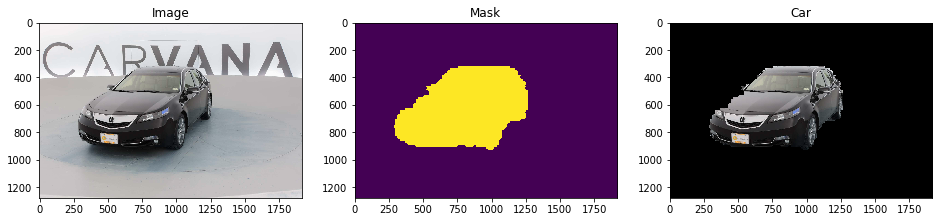

In [199]:
def test_segmentation(img_num):
    # Load an image from testing dataset
    if os.path.exists('Pickles/test_imgs.pickle'):
        with open('Pickles/test_imgs.pickle','rb') as f:
            test_imgs = pickle.load(f)
        f.close()
    else:
        print('Error! Test Images Pickle not found!')

    palt,numt=patchify(test_imgs[img_num],(33,33))
    itr_size=100
    torch.cuda.empty_cache()
    num_itr=int(float(numt)/float(itr_size))
    if not (numt%itr_size)==0:
        num_itr+=1
    patched=predict_img(net,palt[0:itr_size],numt)
    for itr in range(num_itr):
    #    patched = predict_img(net,palt[0:2000],numt)
        if itr<(num_itr-2):
            patched.extend(predict_img(net,palt[int((itr+1)*itr_size):int((itr+2)*itr_size)],numt))
        elif itr==(num_itr-2):
            patched.extend(predict_img(net,palt[int((itr+1)*itr_size):],numt))
        else:
            continue
    patched=np.array(patched)
    print(patched.shape)
    final_patches_r=[]
    final_patches_g=[]
    final_patches_b=[]
    for i in range(patched.shape[0]):
        for j in range(patched[i].shape[0]):
            img_seg=np.zeros((3,patched[i].shape[2],patched[i].shape[3]))
            #RGB Colour Code-> black(0,0,0):0,else  red(255,0,0):1,necrosis  blue(0,0,255):2,edema  green(0,255,0):3,non-enhancing tumor  yellow(255,255,0):4,enhancing tumor
            for k in range(patched[i].shape[1]):
                img_seg[0] += (patched[i][j][k])*(255.0*(k==1 or k==4))#red
                img_seg[1] += (patched[i][j][k])*(255.0*(k==3 or k==4))#green
                img_seg[2] += (patched[i][j][k])*(255.0*(k==2))#green
            final_patches_r.append(np.array(img_seg[0]))
            final_patches_g.append(np.array(img_seg[1]))
            final_patches_b.append(np.array(img_seg[2]))
    final_patches_r=np.array(final_patches_r)
    print(final_patches_r.shape)
    final_patches_g=np.array(final_patches_g)
    print(final_patches_g.shape)
    final_patches_b=np.array(final_patches_b)
    print(final_patches_b.shape)
    final_patches=[final_patches_r,final_patches_g,final_patches_b]
    mask=[]
    for i in range(3):
          mask.append(depatchify(final_patches[i],(240,240)))
    mask=np.array(mask).transpose((1,2,0))
    print(mask.shape)

    plt.figure(figsize = (10,10))
    for i in range(4):
        plt.subplot(2,2,i+1)
        plt.imshow(test_imgs[img_num][i],cmap='gray')
    plt.title("4-Channel-Testing Patch {}".format(img_num))

    plt.figure(figsize = (5,5))
    plt.imshow(mask,cmap='gray')#vmax=img_seg.max())
    plt.title('Tumor')

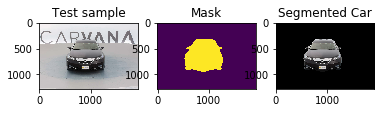

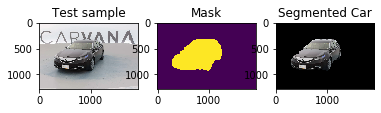

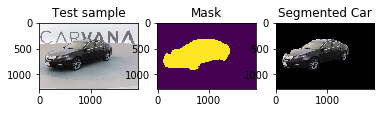

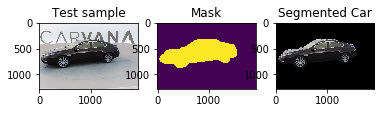

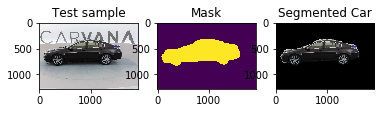

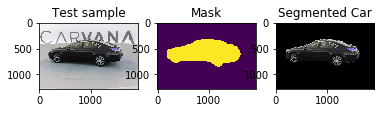

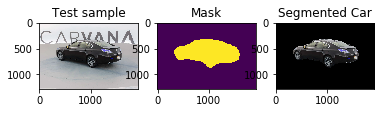

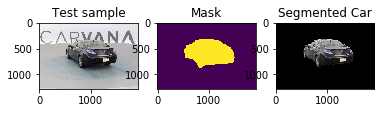

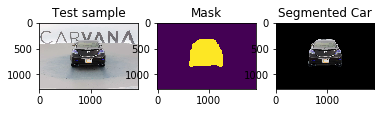

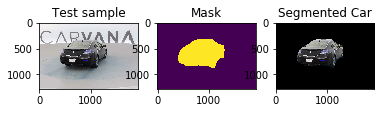

In [200]:
test_segmentation(3)    

In [ ]:
for i in range(3):
    test_segmentation(i+3)